In [1]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import numpy as np
import joblib
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score
import tqdm as notebook_tqdm
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBClassifier #continuous values?

c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## only when sample is not being loaded externally

In [14]:
df = pd.read_csv(r"C:\Users\odiee\OneDrive\Documents\24-25\Blok4\HCML\Project\Notebooks\ACSPUMS1.csv")

In [24]:
print(df.head())
df.isna().sum()

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
1     17      2    1    5      2    2      N         1    0    12    43   
2      6      2    2    5      1    1   4853         1    0    18    58   
3     12      1    1    5      2    2      N         1    0    12    25   
4     14      1    1    5      1    2  611M1         1    0    16    21   

   PINCP  WKHP  Unnamed: 13  
0  63000    80          NaN  
1      0     0          NaN  
2  23100    20          NaN  
3      0     0          NaN  
4  17000    40          NaN  


PWGTP                 0
RAC1P                 0
SEX                   0
MAR                   0
HICOV                 0
DIS                   0
NAICSP                0
NATIVITY              0
ENG                   0
SCHL                  0
AGEP                  0
PINCP                 0
WKHP                  0
Unnamed: 13    15912393
dtype: int64

In [28]:
print("NAICSP dtype:", df['NAICSP'].dtype)
print("Unique values (sample):", df['NAICSP'].unique()[:10])

NAICSP dtype: object
Unique values (sample): ['23' 'N' '4853' '611M1' '562' '722Z' '6216' '4551' '721M' '5617Z']


In [15]:
# filter out NaN column
df = df.drop(columns=['Unnamed: 13', 'PWGTP'], errors='ignore')

# preprocess NAICS
df = df[df['NAICSP'] !='N']
df = df[df['NAICSP'] !='999920']

In [4]:
# Check for '999920' as a string
print("'999920' in NAICSP?", '999920' in df['NAICSP'].astype(str).values)

# Check for 999920 as an integer
print("999920 in NAICSP?", 999920 in df['NAICSP'].values)

print("'N' in NAICSP?", 'N' in df['NAICSP'].astype(str).values)

'999920' in NAICSP? False
999920 in NAICSP? False
'N' in NAICSP? False


In [27]:
print(df.head())

   RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  PINCP  WKHP
0      1    1    1      2    2     23         1    0    17    35  63000    80
2      2    2    5      1    1   4853         1    0    18    58  23100    20
4      1    1    5      1    2  611M1         1    0    16    21  17000    40
5      1    1    2      2    2    562         1    0    12    45   7700    50
6      6    2    5      1    2  611M1         2    0    19    21   2000    15


### Pre-processing - regrouping data

In [16]:
raw_data = df.copy()

# Categorize AGEP into bins
age_bins = [18, 25, 45, 60, float('inf')]
age_labels = ['18_25','25_45', '45_60', '60_plus']
raw_data['AGEP'] = pd.cut(raw_data['AGEP'], bins=age_bins, labels=age_labels, right=False)
raw_data = raw_data.dropna(subset=['AGEP'])
# Binarize MAR
raw_data['MAR'] = raw_data['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
raw_data = raw_data[raw_data['RAC1P'].isin(valid_rac1p_values)]


In [17]:
raw_data.head()

,RAC1P,SEX,MAR,HICOV,DIS,NAICSP,NATIVITY,ENG,SCHL,AGEP,PINCP,WKHP
0,1,1,1,2,2,23,1,0,17,25_45,63000,80
2,2,2,0,1,1,4853,1,0,18,45_60,23100,20
4,1,1,0,1,2,611M1,1,0,16,18_25,17000,40
5,1,1,0,2,2,562,1,0,12,45_60,7700,50
6,6,2,0,1,2,611M1,2,0,19,18_25,2000,15


### Pre-processing: subsampling data

In [18]:
raw_data['strata'] = raw_data[['DIS', 'NATIVITY','RAC1P','SEX', 'AGEP', 'MAR']].astype(str).agg('_'.join, axis=1)

sample,_ = train_test_split(raw_data, 
                             train_size=500000, 
                             stratify=raw_data['strata'], 
                             random_state=42)

In [35]:
len(sample)

500000

### Check for proportions

In [36]:
print(raw_data['DIS'].value_counts(normalize=True))
print(sample['DIS'].value_counts(normalize=True)) 

print(raw_data['NATIVITY'].value_counts(normalize=True))
print(sample['NATIVITY'].value_counts(normalize=True))

print(raw_data['SEX'].value_counts(normalize=True))
print(sample['SEX'].value_counts(normalize=True))

DIS
2    0.903569
1    0.096431
Name: proportion, dtype: float64
DIS
2    0.903568
1    0.096432
Name: proportion, dtype: float64
NATIVITY
1    0.856041
2    0.143959
Name: proportion, dtype: float64
NATIVITY
1    0.85604
2    0.14396
Name: proportion, dtype: float64
SEX
1    0.513448
2    0.486552
Name: proportion, dtype: float64
SEX
1    0.513446
2    0.486554
Name: proportion, dtype: float64


In [37]:
print(raw_data['RAC1P'].value_counts(normalize=True))
print(sample['RAC1P'].value_counts(normalize=True))

RAC1P
1    0.710612
2    0.086609
9    0.085958
6    0.064260
8    0.052561
Name: proportion, dtype: float64
RAC1P
1    0.710612
2    0.086610
9    0.085956
6    0.064260
8    0.052562
Name: proportion, dtype: float64


In [19]:
print(raw_data['AGEP'].value_counts(normalize=True))
print(sample['AGEP'].value_counts(normalize=True))

AGEP
25_45      0.369033
45_60      0.279616
60_plus    0.231918
18_25      0.119433
Name: proportion, dtype: float64
AGEP
25_45      0.369032
45_60      0.279622
60_plus    0.231916
18_25      0.119430
Name: proportion, dtype: float64


In [20]:
sample.drop('strata', axis=1, inplace=True)
print(sample.head())

          RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL     AGEP  \
10788649      1    1    1      1    2    516         1    0    22    45_60   
14149460      1    1    1      1    1   92MP         1    0    21    25_45   
8600710       1    1    1      1    2     23         1    0    19    25_45   
15588166      9    1    0      2    2     23         2    4     9    25_45   
4710139       1    1    1      1    1    337         1    0    20  60_plus   

           PINCP  WKHP  
10788649  202800    40  
14149460   48000    60  
8600710    50000    40  
15588166   25000    40  
4710139    35400    18  


In [21]:
sample.to_csv("sample_data.csv", index=False)


## load sample

In [5]:
sample = pd.read_csv("sample_data.csv")

In [6]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP','DIS', 'NATIVITY','NAICSP','SCHL', 'MAR', 'ENG', 'SEX',  'RAC1P']

In [7]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

In [8]:
insurance_data.rename(columns={"HICOV": "target"}, inplace=True)

In [9]:
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [10]:
print(insurance_data.columns)
print(income_data.columns)

Index(['RAC1P', 'SEX', 'MAR', 'target', 'DIS', 'NAICSP', 'NATIVITY', 'ENG',
       'SCHL', 'AGEP', 'PINCP', 'WKHP'],
      dtype='object')
Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'NATIVITY', 'ENG', 'SCHL',
       'AGEP', 'target', 'WKHP'],
      dtype='object')


In [59]:
print(insurance_data['NAICSP'].unique())


['516' '92MP' '23' '337' '5411' '492' '333MS' '32411' '5416' '6241'
 '611M1' '5415' '52M2' '6111' '5313' '56173' '9211MP' '4552' '812112'
 '52M3' '5614' '6212' '6214' '9281P' '92119' '8122' '6211' '5613' '722Z'
 '484' '481' '522M' '4241' '6244' '334M1' '923' '5241' '44511' '4581'
 '3114' '8111Z' '5615' '622M' '3327' '8113' '332MZ' '331M' '8121M' '5121'
 '531M' '491' '3252' '31411' '3345' '45611' '6213ZM' '3391' '51929'
 '44414' '8131' '6231' '4248' '7224' '33299M' '562' '92811P3' '5413'
 '92M1' '713Z' '5412' '92M2' '4411' '4237' '611M3' '5242' '4441Z' '621M'
 '335M' '488' '5617Z' '3315' '4238' '485M' '812111' '487' '1133' '813M'
 '4452' '3MS' '2212P' '8129' '112' '814' '4MS' '6216' '561M' '2213M'
 '5418' '3272' '517111' '5417' '3219ZM' '54194' '336M' '711M' '113M'
 '42393' '5616' '4244' '4239Z' '5419Z' '55' '4236' '4413' '92113' '493'
 '33641M1' '4599' '3335' '7211' '8114' '92811P4' '811192' '32621' '3399ZM'
 '92811P1' '712' '4582' '424M' '45921' '7111' '4551' '2211P' '3261'
 '33311' '

## Data analysis/visualization

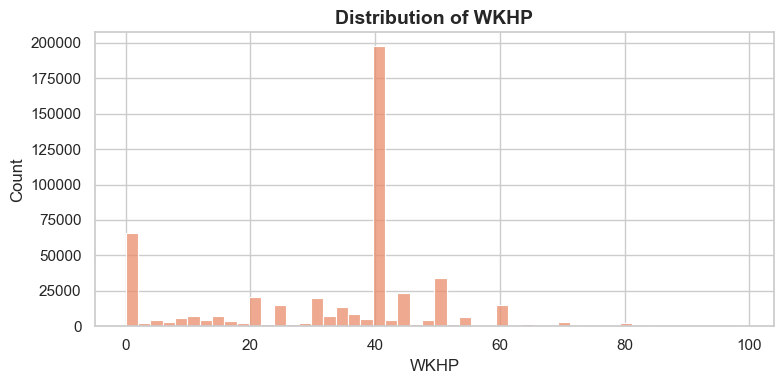

In [46]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(insurance_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Categorical value visualization

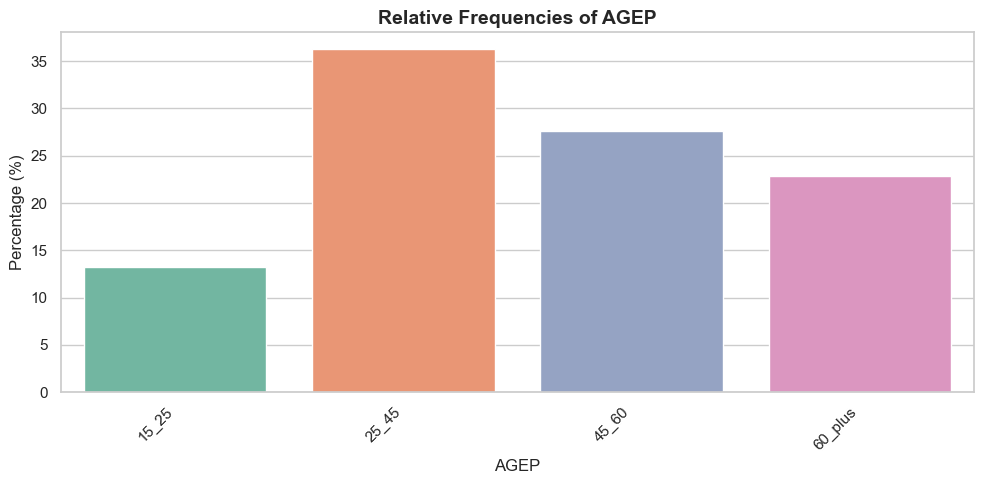

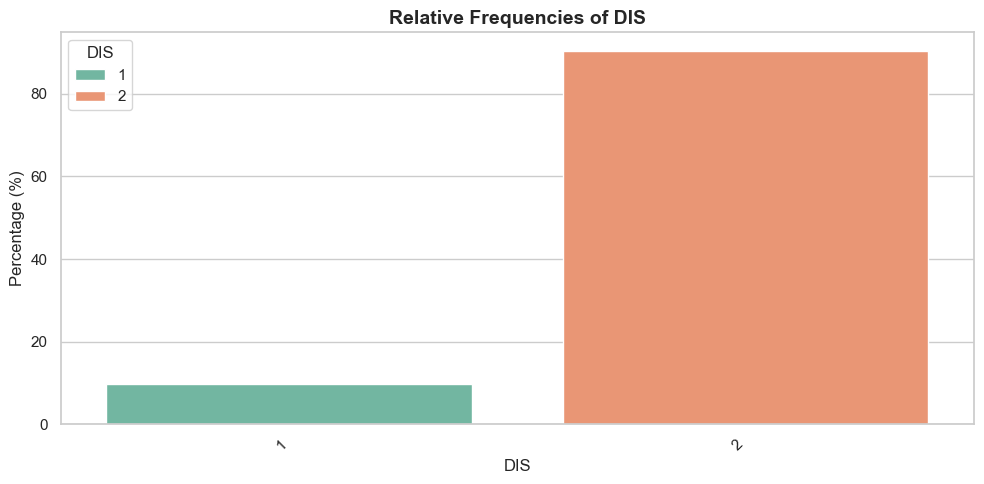

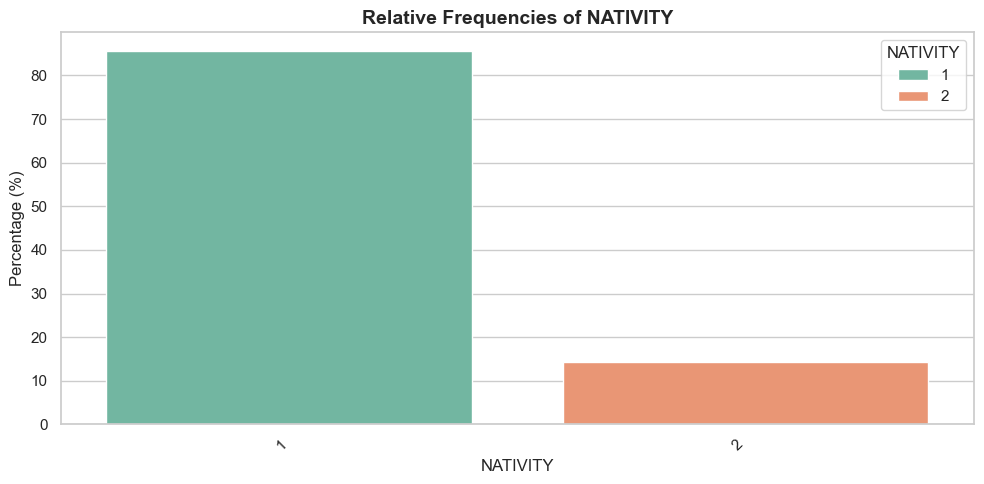

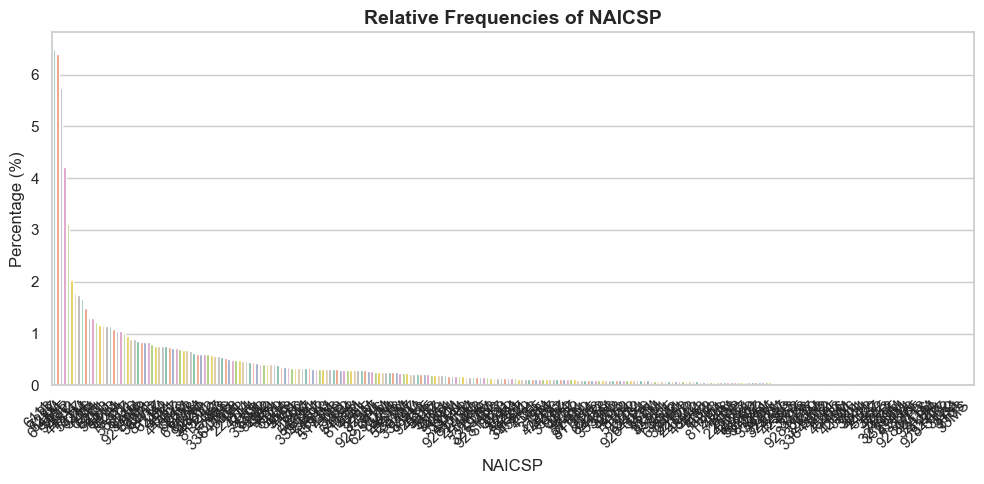

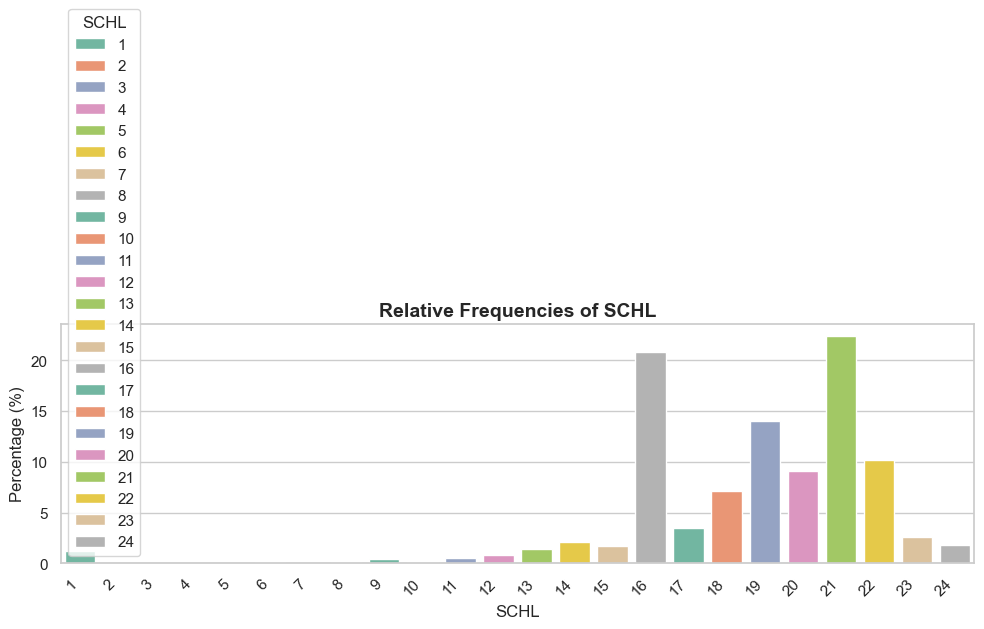

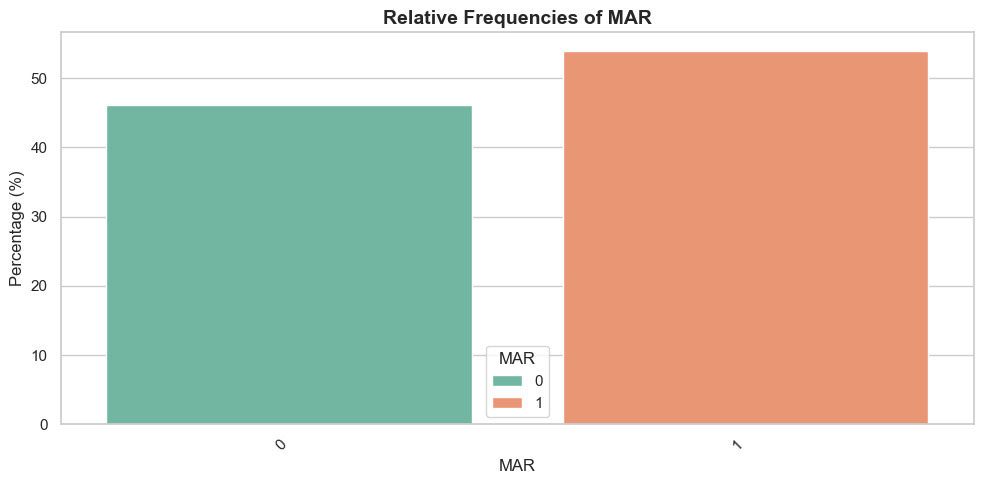

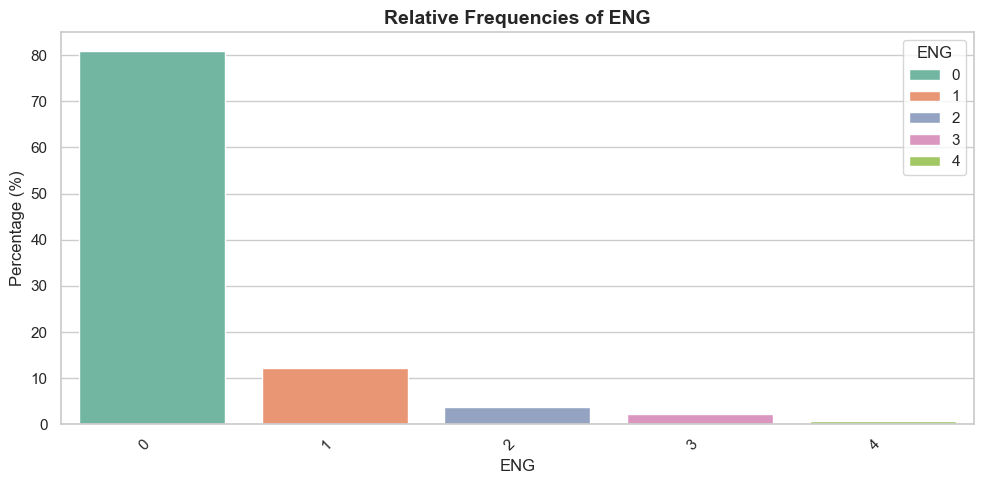

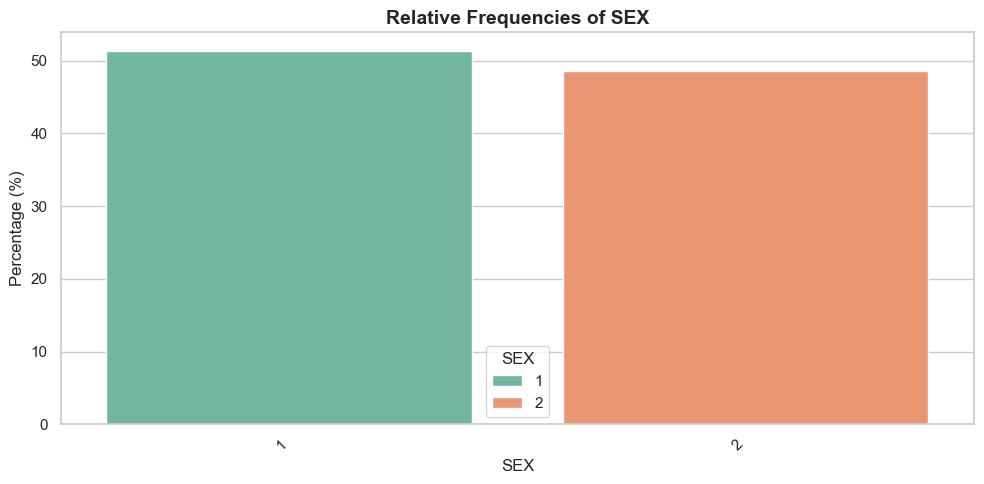

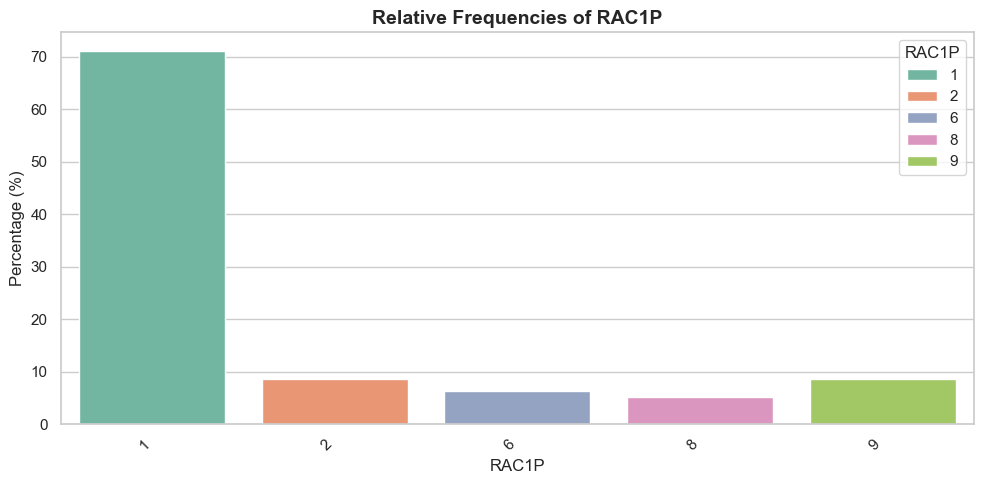

In [47]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = insurance_data[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating thresholds and splitting datasets

### Income dataset

In [43]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test_inc, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test_inc)


In [44]:
print(X.columns)

Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'NATIVITY', 'ENG', 'SCHL',
       'AGEP', 'WKHP'],
      dtype='object')


In [45]:
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

### Health care dataset

In [46]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test_h, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test_h)


In [47]:
y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [16]:
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

In [16]:
print(len(all_feature_names_income))

311


In [17]:
print(X_test_income.shape)

(75000, 311)


### Linear baseline model for performance comparison ?

In [ ]:
#logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
#logreg.fit(X_train_enc, y_train)
#y_pred_logreg = logreg.predict(X_test_enc)
#print(classification_report(y_test, y_pred_logreg))


## XGBoost Classifier

In [32]:
def tune_xgb_classifier(X_train, y_train, X_val, y_val, X_test, y_test, n_iter=20, random_state=42):
    param_dist = {
        'n_estimators': randint(100, 700),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for i, params in enumerate(param_list):
        print(f"\n Running trial {i+1}/{n_iter}...")
        print("Params:", params)
        start = time.time()

        model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **params)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        duration = time.time() - start
        print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

        results.append((params, val_f1))

    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest Hyperparameters:", best_params)
    print(f"Best Validation F1 (macro): {best_score:.4f}")

    # Train best model on full training data
    best_model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params)
    best_model.fit(X_train, y_train)

    y_test_pred = best_model.predict(X_test)
    print("\nFinal Test Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return best_model, best_params, best_score


In [19]:
# For income prediction
xgmodel_income, params_income, score_income = tune_xgb_classifier(
    X_train_income, y_train_income, X_val_income, y_val_income, X_test_income, y_test_income
)

# For healthcare prediction
xgmodel_health, params_health, score_health = tune_xgb_classifier(
    X_train_health, y_train_health, X_val_health, y_val_health, X_test_health, y_test_health
)



 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}
Finished trial 1/20 — Val F1 (macro): 0.7894 — Time: 3.0s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}
Finished trial 2/20 — Val F1 (macro): 0.7755 — Time: 7.2s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_dept

KeyboardInterrupt: 

In [60]:
print(params_income)

{'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}


In [33]:
params_income = {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}

In [61]:
print(params_health)

{'colsample_bytree': np.float64(0.8477580432130638), 'gamma': np.float64(0.6966572720293784), 'learning_rate': np.float64(0.1913252137833452), 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': np.float64(0.22879816549162246), 'reg_lambda': np.float64(0.07697990982879299), 'subsample': np.float64(0.6448757264568841)}


In [34]:
params_health = {'colsample_bytree': np.float64(0.8477580432130638), 'gamma': np.float64(0.6966572720293784), 'learning_rate': np.float64(0.1913252137833452), 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': np.float64(0.22879816549162246), 'reg_lambda': np.float64(0.07697990982879299), 'subsample': np.float64(0.6448757264568841)}

## TreeSHAP

### Income classifier

In [35]:
#params_income = {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}

best_model_income = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_income
)
best_model_income.fit(X_train_income, y_train_income)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6872700594236812), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(4.75357153204958), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.22959818254342154), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=221, n_jobs=-1,
              num_parallel_tree=None, ...)

In [37]:
print(y_test_income.shape)

(75000,)


In [38]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_income = best_model_income.predict(X_test_income)
y_pred_proba_income = best_model_income.predict_proba(X_test_income)[:, 1] 


print("Accuracy:", accuracy_score(y_test_income, y_pred_income))
print("Classification Report:\n", classification_report(y_test_income, y_pred_income))



Accuracy: 0.7933733333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82     43722
           1       0.75      0.75      0.75     31278

    accuracy                           0.79     75000
   macro avg       0.79      0.79      0.79     75000
weighted avg       0.79      0.79      0.79     75000



In [40]:
results_df = pd.DataFrame(X_test_income.toarray(), columns=[f'feature_{i}' for i in range(X_test_income.shape[1])])

# Add target and predictions
results_df['y_true'] = y_test_income.values
results_df['y_pred'] = y_pred_income
results_df['y_pred_proba'] = y_pred_proba_income

# Save to CSV
results_df.to_csv('income_test_predictions.csv', index=False)

In [41]:
income_explainer = shap.Explainer(best_model_income, feature_names = all_feature_names_income)
shap_values_income = income_explainer(X_test_income)

In [42]:
# locally saving shap values
np.save("treeshap_values_income.npy", shap_values_income.values)

with open("treeshap_values_income.pkl", "wb") as f:
    pickle.dump(shap_values_income, f)

joblib.dump(shap_values_income, "treeshap_explainer_income.joblib")

['treeshap_explainer_income.joblib']

In [49]:
mean_abs_shap_income = np.abs(shap_values_income.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_income)[-20:][::-1]

original_feature_names = shap_values_income.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_0': 'Not married',
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_income.feature_names = renamed_features

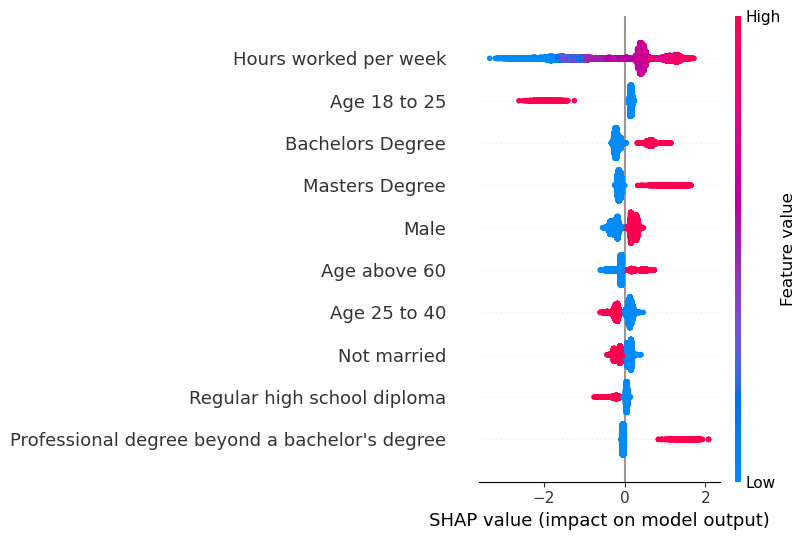

In [51]:
X_test_income_df = pd.DataFrame(X_test_income.toarray(), columns=original_feature_names)  # Use toarray() if sparse

X_test_income_df.columns = renamed_features

shap.summary_plot(shap_values_income, X_test_income_df, max_display=10)


### Health care classifier

In [52]:
#params_health = {'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}

best_model_health = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_health
)
best_model_health.fit(X_train_health, y_train_health)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8477580432130638), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.6966572720293784), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1913252137833452), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=640, n_jobs=-1,
              num_parallel_tree=None, ...)

In [53]:
health_explainer = shap.Explainer(best_model_health, feature_names = all_feature_names_health)
shap_values_health = health_explainer(X_test_health)

In [54]:
# locally savin gshap values

np.save("treeshap_values_health.npy", shap_values_health.values)

with open("treeshap_values_health.pkl", "wb") as f:
    pickle.dump(shap_values_health, f)

joblib.dump(shap_values_health, "treeshap_explainer_health.joblib")

['treeshap_explainer_health.joblib']

In [55]:
y_pred_health = best_model_health.predict(X_test_health)
y_pred_proba_health = best_model_health.predict_proba(X_test_health)[:, 1] 


print("Accuracy:", accuracy_score(y_test_health, y_pred_health))
print("Classification Report:\n", classification_report(y_test_health, y_pred_health))

Accuracy: 0.9083733333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.15      0.23      6589
           1       0.92      0.98      0.95     68411

    accuracy                           0.91     75000
   macro avg       0.68      0.57      0.59     75000
weighted avg       0.88      0.91      0.89     75000



In [56]:
results_df = pd.DataFrame(X_test_health.toarray(), columns=[f'feature_{i}' for i in range(X_test_health.shape[1])])

# Add target and predictions
results_df['y_true'] = y_test_health.values
results_df['y_pred'] = y_pred_health
results_df['y_pred_proba'] = y_pred_proba_health

# Save to CSV
results_df.to_csv('health_test_predictions_XGBoost.csv', index=False)

In [57]:
mean_abs_shap_health = np.abs(shap_values_health.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_health)[-20:][::-1]

original_feature_names = shap_values_health.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_5': 'Never married',
    'ENG_0': 'Speaks only English',
    'NAICSP_23': 'Industry: Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NATIVITY_1': 'Native',
    'MAR_0': 'Not married',
}



renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_health.feature_names = renamed_features

In [60]:
print(X_test_health.toarray().shape)              # Should be (75000, 312)
print(len(original_feature_names))                # Should be 312
print(len(renamed_features))                      # Should be 312
original_feature_names = original_feature_names[:312]
renamed_features = renamed_features[:312]


(75000, 312)
313
313


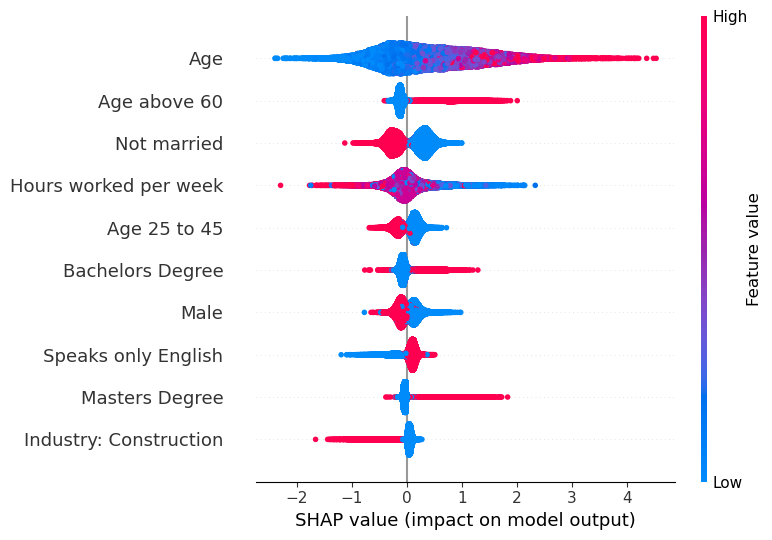

In [61]:
X_test_health_df = pd.DataFrame(X_test_health.toarray(), columns=original_feature_names)  # Use toarray() if sparse

X_test_health_df.columns = renamed_features

shap.summary_plot(shap_values_health, X_test_health_df, max_display=10)

## Simple FFNN

In [64]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

def train_ffnn_for_task(X_train, y_train, X_val, y_val, input_dim, n_iter=10, random_state=42):
    np.random.seed(random_state)

    param_dist = {
        'hidden_units': [32, 64, 128],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [1e-2, 1e-3, 1e-4],
        'batch_size': [32, 64],
        'epochs': [10, 20]
    }

    def sample_params(param_dist):
        return {k: np.random.choice(v) for k, v in param_dist.items()}

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    results = []

    for i in range(n_iter):
        params = sample_params(param_dist)
        print(f"Trial {i+1}/{n_iter} with params: {params}")

        model = build_ffnn(
            input_dim=input_dim,
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0,
            class_weight=class_weights
        )

        val_preds = model.predict(X_val).ravel()
        val_auc = roc_auc_score(y_val, val_preds)
        print(f"Val AUC: {val_auc:.4f}\n")

        results.append((params, val_auc))

    best_params, best_val_auc = max(results, key=lambda x: x[1])
    print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")

    # Train best model on full data (optionally)
    best_model = build_ffnn(
        input_dim=input_dim,
        hidden_units=best_params['hidden_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    best_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        class_weight=class_weights
    )

    return best_model, best_params, best_val_auc


In [32]:
input_dim_income = X_train_income.shape[1]
print("\n=== Training for Task: Income ===")
ffnn_model_income, params_income, auc_income = train_ffnn_for_task(
    X_train_income, y_train_income, X_val_income, y_val_income, input_dim_income
)

input_dim_health = X_train_health.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_health, params_health, auc_health = train_ffnn_for_task(
    X_train_health, y_train_health, X_val_health, y_val_health, input_dim_health
)



=== Training for Task: Income ===
Trial 1/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Val AUC: 0.8799

Trial 2/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
Val AUC: 0.8771

Trial 3/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Val AUC: 0.8782

Trial 4/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Val AUC: 0.8764

Trial 5/10 with

### Income model with given params

In [62]:
# income
best_params_income = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}

In [65]:
ffnn_model_income = build_ffnn(
    input_dim=X_train_income.shape[1],  # or whatever your feature dim is
    hidden_units=int(best_params_income['hidden_units']),
    dropout_rate=float(best_params_income['dropout_rate']),
    learning_rate=float(best_params_income['learning_rate'])
)

In [66]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_income), y=y_train_income)
class_weights = dict(zip(np.unique(y_train_income), cw))

ffnn_model_income.fit(
    X_train_income, y_train_income,
    epochs=int(best_params_income['epochs']),
    batch_size=int(best_params_income['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_income, y_val_income)
)


Epoch 1/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - AUC: 0.7846 - loss: 0.5727 - val_AUC: 0.8680 - val_loss: 0.4554
Epoch 2/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - AUC: 0.8665 - loss: 0.4535 - val_AUC: 0.8712 - val_loss: 0.4460
Epoch 3/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - AUC: 0.8691 - loss: 0.4492 - val_AUC: 0.8720 - val_loss: 0.4449
Epoch 4/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - AUC: 0.8717 - loss: 0.4448 - val_AUC: 0.8733 - val_loss: 0.4461
Epoch 5/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8743 - loss: 0.4410 - val_AUC: 0.8736 - val_loss: 0.4439
Epoch 6/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8739 - loss: 0.4415 - val_AUC: 0.8740 - val_loss: 0.4426
Epoch 7/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - AUC: 0.8741 - loss: 0.4412 - val_AUC: 0.8745 - val_loss: 0.4463
Epoch 8/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8766 - loss: 0.4376 - val_AUC: 0.8747 - val_loss: 0.4549
Epoch 9/20
10938

In [67]:
np.savez(
    "ffnn_income_data.npz",
    X_test=X_test_income.toarray() if hasattr(X_test_income, 'toarray') else X_test_income,
    y_true=y_test_income,
    y_pred=y_pred_income
)


### Health insurance model with given params

In [68]:
# health
best_params_health = {'hidden_units': np.int64(64), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
 #Best Val AUC: 0.8816

In [69]:
ffnn_model_health = build_ffnn(
    input_dim=X_train_health.shape[1],  # or whatever your feature dim is
    hidden_units=int(best_params_health['hidden_units']),
    dropout_rate=float(best_params_health['dropout_rate']),
    learning_rate=float(best_params_health['learning_rate'])
)

In [70]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_health), y=y_train_health)
class_weights = dict(zip(np.unique(y_train_health), cw))

ffnn_model_health.fit(
    X_train_health, y_train_health,
    epochs=int(best_params_health['epochs']),
    batch_size=int(best_params_health['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_health, y_val_health)
)

Epoch 1/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - AUC: 0.5136 - loss: 374.1114 - val_AUC: 0.7046 - val_loss: 0.7660
Epoch 2/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - AUC: 0.5571 - loss: 11.7564 - val_AUC: 0.3848 - val_loss: 1.5408
Epoch 3/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.6287 - loss: 1.1621 - val_AUC: 0.6909 - val_loss: 0.7506
Epoch 4/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.6267 - loss: 0.6837 - val_AUC: 0.6966 - val_loss: 0.7224
Epoch 5/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.6416 - loss: 0.6852 - val_AUC: 0.7023 - val_loss: 0.7079
Epoch 6/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.6504 - loss: 0.6725 - val_AUC: 0.7185 - val_loss: 0.7391
Epoch 7/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.6565 - loss: 0.6675 - val_AUC: 0.7289 - val_loss: 0.7297
Epoch 8/20
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.6598 - loss: 0.6722 - val_AUC: 0.7147 - val_loss: 0.7349
Epoch 9/20
5469/5469 ━━━━━━━━

In [71]:
np.savez(
    "ffnn_health_data.npz",
    X_test=X_test_health.toarray() if hasattr(X_test_health, 'toarray') else X_test_health,
    y_true=y_test_health,
    y_pred=y_pred_health
)


In [72]:
# test set evluation

print("\n=== Test Performance: Income ===")
test_preds_income = ffnn_model_income.predict(X_test_income).ravel()
test_auc_income = roc_auc_score(y_test_income, test_preds_income)
print(f"Test AUC: {test_auc_income:.4f}")
print(classification_report(y_test_income, test_preds_income > 0.5))

print("\n=== Test Performance: Insurance ===")
test_preds_health = ffnn_model_health.predict(X_test_health).ravel()
test_auc_health = roc_auc_score(y_test_health, test_preds_health)
print(f"Test AUC: {test_auc_health:.4f}")
print(classification_report(y_test_health, test_preds_health > 0.5))



=== Test Performance: Income ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test AUC: 0.8767
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     43722
           1       0.72      0.81      0.76     31278

    accuracy                           0.79     75000
   macro avg       0.79      0.79      0.79     75000
weighted avg       0.80      0.79      0.79     75000


=== Test Performance: Insurance ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test AUC: 0.7290
              precision    recall  f1-score   support

           0       0.21      0.56      0.31      6589
           1       0.95      0.79      0.87     68411

    accuracy                           0.77     75000
   macro avg       0.58      0.68      0.59     75000
weighted avg       0.88      0.77      0.82     75000



## DeepSHAP

### Income

c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5000, 311))']
  warnings.warn(msg)
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10000, 311))']
  warnings.warn(msg)


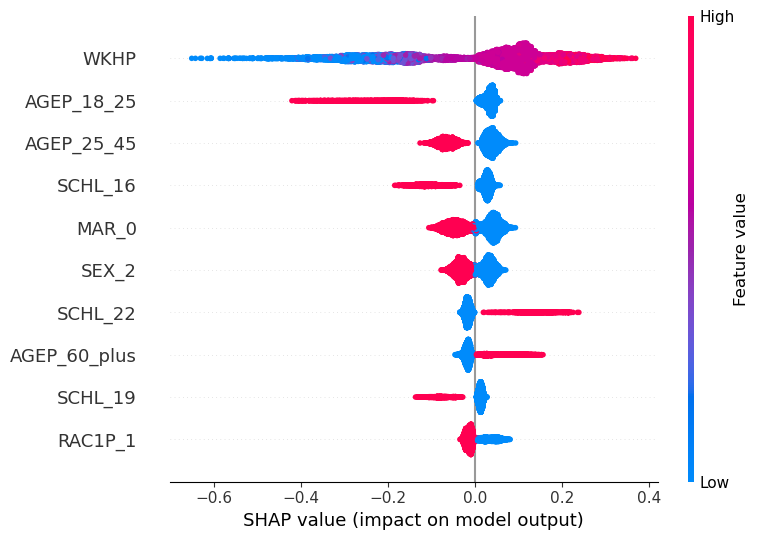

In [73]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_income, y_train_income))
 
# stratified sample from test set
X_test_array = X_test_income.toarray() if hasattr(X_test_income, "toarray") else X_test_income
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test_income))
X_test_sample_income = X_test_array[test_sample_idx]
 
# set background
background = X_train_income[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_income_NN = shap.DeepExplainer(ffnn_model_income, background)
deep_shap_values_income = explainer_income_NN.shap_values(X_test_sample_income).squeeze(-1)

shap.summary_plot(deep_shap_values_income, X_test_sample_income, feature_names=all_feature_names_income, max_display=10)


In [74]:
# locally saving shap values
np.save("deepshap_values_income.npy", deep_shap_values_income)

with open("deepshap_values_income.pkl", "wb") as f:
    pickle.dump(deep_shap_values_income, f)

joblib.dump(deep_shap_values_income, "deepshap_explainer_income.joblib")

['deepshap_explainer_income.joblib']

In [75]:
# Save test input
df_x_test_sample = pd.DataFrame(X_test_sample_income, columns=all_feature_names_income)
df_x_test_sample.to_csv('X_test_sample_income.csv', index=False)


### Health insurance

c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(5000, 312))']
  warnings.warn(msg)
c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(10000, 312))']
  warnings.warn(msg)


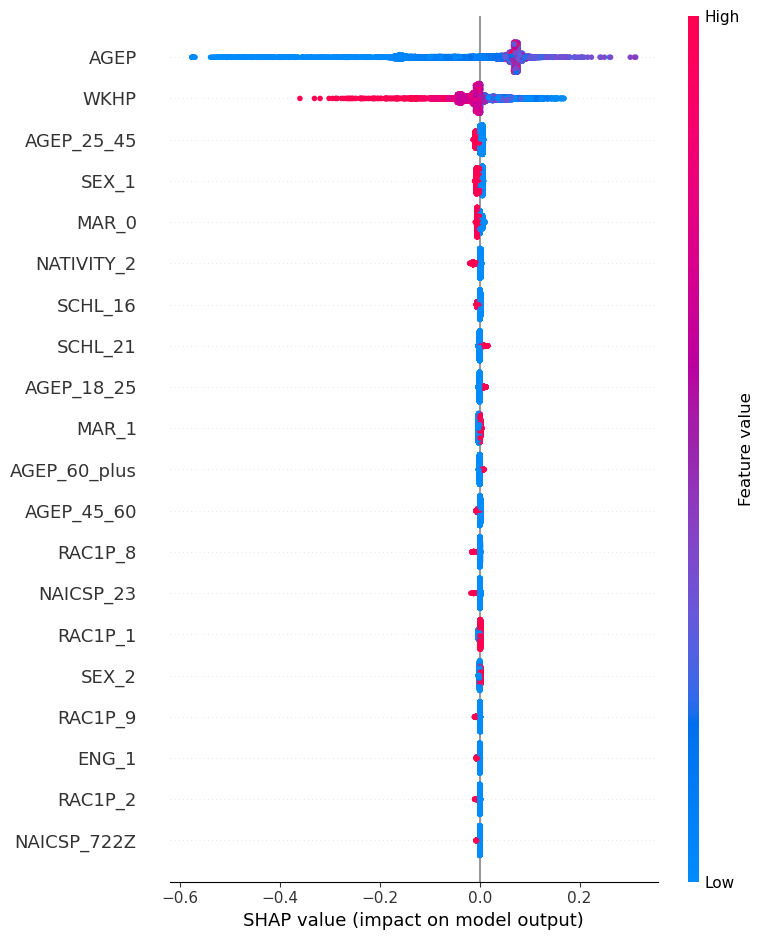

In [76]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_health, y_train_health))
 
# stratified sample from test set
X_test_array = X_test_health.toarray() if hasattr(X_test_health, "toarray") else X_test_health
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test_health))
X_test_sample_health = X_test_array[test_sample_idx]
 
# set background
background = X_train_health[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_health_NN = shap.DeepExplainer(ffnn_model_health, background)
deep_shap_values_health = explainer_health_NN.shap_values(X_test_sample_health).squeeze(-1)
 
shap.summary_plot(deep_shap_values_health, X_test_sample_health, feature_names=all_feature_names_health, max_display=20)


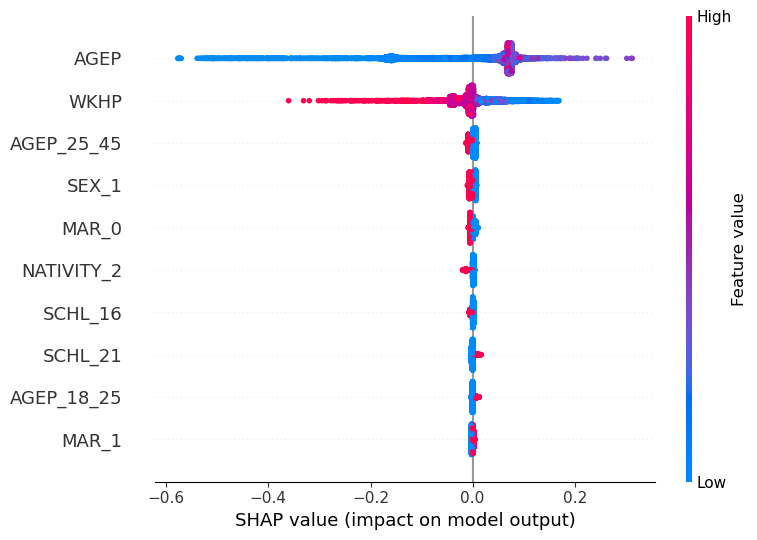

In [77]:
shap.summary_plot(deep_shap_values_health, X_test_sample_health, feature_names=all_feature_names_health, max_display=10)


In [78]:
# locally saving shap values
np.save("deepshap_values_health.npy", deep_shap_values_health
        )

with open("deepshap_values_health.pkl", "wb") as f:
    pickle.dump(deep_shap_values_health, f)


joblib.dump(deep_shap_values_health, "deepshap_explainer_health.joblib")

['deepshap_explainer_health.joblib']

In [81]:
# Save test input
df_x_test_sample = pd.DataFrame(X_test_sample_health, columns=all_feature_names_health[:312])
df_x_test_sample.to_csv('X_test_sample_health.csv', index=False)


# Statistics

In [2]:
shap_values_tp_health = np.load("treeshap_values_health.npy")
shap_values_tp_income = np.load("treeshap_values_income.npy")
shap_values_dp_health = np.load("deepshap_values_health.npy")
shap_values_dp_income = np.load("deepshap_values_income.npy")

In [3]:
income_df = sample = pd.read_csv("income_test_predictions_XGBoost.csv")
health_df = sample = pd.read_csv("health_test_predictions_XGBoost.csv")

## naics

In [54]:
def cohend(d1, d2):
    d1 = np.array(d1)
    d2 = np.array(d2)

    # Remove NaNs
    d1 = d1[~np.isnan(d1)]
    d2 = d2[~np.isnan(d2)]

    if len(d1) < 2 or len(d2) < 2:
        return np.nan

    s1 = np.var(d1, ddof=1)
    s2 = np.var(d2, ddof=1)
    s = np.sqrt(((len(d1) - 1)*s1 + (len(d2) - 1)*s2) / (len(d1) + len(d2) - 2))

    if s == 0 or np.isnan(s):
        return np.nan

    return (np.mean(d1) - np.mean(d2)) / s


In [ ]:
data = """
211: EXT-Oil And Gas Extraction
2121: EXT-Coal Mining
2122: EXT-Metal Ore Mining
2123: EXT-Nonmetallic Mineral Mining And Quarrying
213: EXT-Support Activities For Mining
2211P: UTL-Electric Power Generation, Transmission And Distribution
2212P: UTL-Natural Gas Distribution
22132: UTL-Sewage Treatment Facilities
2213M: UTL-Water Supply And Irrigation Systems, And Steam And Air-Conditioning Supply
221MP: UTL-Electric And Gas, And Other Combinations
22S: UTL-Not Specified Utilities
23: CON-Construction (The Cleaning Of Buildings And Dwellings Is Incidental During Construction And Immediately After Construction)
3113: MFG-Sugar And Confectionery Products
3114: MFG-Fruit And Vegetable Preserving And Specialty Food Manufacturing
3115: MFG-Dairy Product Manufacturing
3116: MFG-Animal Slaughtering And Processing
311811: MFG-Retail Bakeries
3118Z: MFG-Bakeries And Tortilla Manufacturing, Except Retail Bakeries
311M1: MFG-Animal Food, Grain And Oilseed Milling
311M2: MFG-Seafood And Other Miscellaneous Foods, N.E.C.
311S: MFG-Not Specified Food Industries
3121: MFG-Beverage Manufacturing
3122: MFG-Tobacco Manufacturing
3131: MFG-Fiber, Yarn, And Thread Mills
3132Z: MFG-Fabric Mills, Except Knit Fabric Mills
3133: MFG-Textile And Fabric Finishing And Fabric Coating Mills
31411: MFG-Carpet And Rug Mills
314Z: MFG-Textile Product Mills, Except Carpet And Rug
315M: MFG-Cut And Sew, And Apparel Accessories And Other Apparel Manufacturing
3162: MFG-Footwear Manufacturing
316M: MFG-Leather And Hide Tanning And Finishing, And Other Leather And Allied Product Manufacturing
31M: MFG-Knit Fabric Mills, And Apparel Knitting Mills
3211: MFG-Sawmills And Wood Preservation
3212: MFG-Veneer, Plywood, And Engineered Wood Product Manufacturing
32199M: MFG-Manufactured Home (Mobile Home) And Prefabricated Wood Building Manufacturing
3219ZM: MFG-Miscellaneous Wood Product Manufacturing
3221: MFG-Pulp, Paper, And Paperboard Mills
32221: MFG-Paperboard Container Manufacturing
3222M: MFG-Miscellaneous Paper And Pulp Products Manufacturing
3231: MFG-Printing And Related Support Activities
32411: MFG-Petroleum Refineries
3241M: MFG-Petroleum And Coal Products Manufacturing, Except Petroleum Refineries
3252: MFG-Resin, Synthetic Rubber, And Artificial And Synthetic Fibers And Filaments Manufacturing
3253: MFG-Pesticide, Fertilizer, And Other Agricultural Chemical Manufacturing
3254: MFG-Pharmaceutical And Medicine Manufacturing
3255: MFG-Paint, Coating, And Adhesive Manufacturing
3256: MFG-Soap, Cleaning Compound, And Toilet Preparation Manufacturing
325M: MFG-Basic Chemical Manufacturing, And Other Chemical Product And Preparation Manufacturing
3261: MFG-Plastics Product Manufacturing
32621: MFG-Tire Manufacturing
3262M: MFG-Rubber Products, Except Tires, Manufacturing
32711: MFG-Pottery, Ceramics, And Plumbing Fixture Manufacturing
32712: MFG-Clay Building Material And Refractories Manufacturing
3272: MFG-Glass And Glass Product Manufacturing
3279: MFG-Other Nonmetallic Mineral Product Manufacturing
327M: MFG-Cement, Concrete, Lime, And Gypsum Product Manufacturing
3313: MFG-Alumina And Aluminum Production And Processing
3314: MFG-Nonferrous Metal (Except Aluminum) Production And Processing
3315: MFG-Foundries
331M: MFG-Iron And Steel Mills And Steel Product Manufacturing
3321: MFG-Forging And Stamping
3322: MFG-Cutlery And Handtool Manufacturing
3327: MFG-Machine Shops; Turned Product; Screw, Nut, And Bolt Manufacturing
3328: MFG-Coating, Engraving, Heat Treating, And Allied Activities
33299M: MFG-Ordnance
332M: MFG-Architectural And Structural Metals, And Boiler, Tank, And Shipping Container Manufacturing
332MZ: MFG-Miscellaneous Fabricated Metal Product Manufacturing
33311: MFG-Agricultural Implement Manufacturing
3331M: MFG-Construction, And Mining And Oil And Gas Field Machinery Manufacturing
3333: MFG-Commercial And Service Industry Machinery Manufacturing
3335: MFG-Metalworking Machinery Manufacturing
3336: MFG-Engine, Turbine, And Power Transmission Equipment Manufacturing
333MS: MFG-Machinery Manufacturing, N.E.C. Or Not Specified
3341: MFG-Computer And Peripheral Equipment Manufacturing
3345: MFG-Navigational, Measuring, Electromedical, And Control Instruments Manufacturing
334M1: MFG-Communications, Audio, And Video Equipment Manufacturing
334M2: MFG-Semiconductor, Magnetic And Optical Media, And Other Electronic Component Manufacturing
3352: MFG-Household Appliance Manufacturing
335M: MFG-Electric Lighting And Electrical Equipment Manufacturing, And Other Electrical Component Manufacturing, N.E.C.
33641M1: MFG-Aircraft, Aircraft Engine, And Aircraft Parts Manufacturing
33641M2: MFG-Guided Missile And Space Vehicle And Parts Manufacturing
3365: MFG-Railroad Rolling Stock Manufacturing
3366: MFG-Ship And Boat Building
3369: MFG-Other Transportation Equipment Manufacturing
336M: MFG-Motor Vehicles And Motor Vehicle Equipment Manufacturing
337: MFG-Furniture And Related Product Manufacturing
3391: MFG-Medical Equipment And Supplies Manufacturing
3399M: MFG-Sporting And Athletic Goods, And Doll, Toy And Game Manufacturing
3399ZM: MFG-Miscellaneous Manufacturing, N.E.C.
33MS: MFG-Not Specified Metal Industries
3MS: MFG-Not Specified Manufacturing Industries
4231: WHL-Motor Vehicle And Motor Vehicle Parts And Supplies Merchant Wholesalers
4232: WHL-Furniture And Home Furnishing Merchant Wholesalers
4233: WHL-Lumber And Other Construction Materials Merchant Wholesalers
4234: WHL-Professional And Commercial Equipment And Supplies Merchant Wholesalers
4235: WHL-Metal and Mineral, Except Petroleum, Merchant Wholesalers
4236: WHL-Household Appliances And Electrical And Electronic Goods Merchant Wholesalers
4237: WHL-Hardware, And Plumbing And Heating Equipment, And Supplies Merchant Wholesalers
4238: WHL-Machinery, Equipment, And Supplies Merchant Wholesalers
42393: WHL-Recyclable Material Merchant Wholesalers
4239Z: WHL-Miscellaneous Durable Goods, Except Recyclable Material, Merchant Wholesalers
4241: WHL-Paper and Paper Product Merchant Wholesalers
4243: WHL-Apparel, Piece Goods, And Notions Merchant Wholesalers
4244: WHL-Grocery And Related Product Merchant Wholesalers
4245: WHL-Farm Product Raw Material Merchant Wholesalers
4247: WHL-Petroleum And Petroleum Products Merchant Wholesalers
4248: WHL-Beer, Wine, And Distilled Alcoholic Beverage Merchant Wholesalers
42491: WHL-Farm Supplies Merchant Wholesalers
4249Z: WHL-Miscellaneous Nondurable Goods Merchant, Except Farm Supplies, Wholesalers
424M: WHL-Drugs, Druggists' Sundries, And Chemical And Allied Products Merchant Wholesalers
4251: WHL-Wholesale Trade Agents And Brokers
42S: WHL-Not Specified Wholesale Trade
4411: RET-Automobile Dealers
4412: RET-Other Motor Vehicle Dealers
4413: RET-Automotive Parts, Accessories, And Tire Retailers
44414: RET-Hardware Retailers
4441Z: RET-Building Material And Supplies Dealers, Except Hardware Retailers
4442: RET-Lawn And Garden Equipment And Supplies Retailers
44511: RET-Supermarkets And Other Grocery (Except Convenience) Retailers
44513: RET-Convenience Retailers And Vending Machine Operators
4452: RET-Specialty Food Retailers
4453: RET-Beer, Wine, And Liquor Retailers
4491: RET-Furniture And Home Furnishings Retailers
4492: RET-Electronics And Appliance Retailers
4551: RET-Department Stores
4552: RET-Warehouse Clubs, Supercenters, And Other General Merchandise Retailers
45611: RET-Pharmacies And Drug Retailers
4561Z: RET-Health And Personal Care, Except Pharmacies And Drug, Retailers
4571: RET-Gasoline Stations
4572: RET-Fuel Dealers
4581: RET-Clothing And Clothing Accessories Retailers
4582: RET-Shoe Retailers
4583: RET-Jewelry, Luggage, And Leather Goods Retailers
45913: RET-Sewing, Needlework, And Piece Goods Retailers
45914: RET-Musical Instrument And Supplies Retailers
4591M: RET-Sporting Goods, And Hobby, Toy, And Game Retailers
45921: RET-Book Retailers And News Dealers
4593: RET-Florists
45941: RET-Office Supplies And Stationery Retailers
45942: RET-Gift, Novelty, And Souvenir Retailers
4595: RET-Used Merchandise Retailers
4599: RET-Other Miscellaneous Retailers
481: TRN-Air Transportation
482: TRN-Rail Transportation
483: TRN-Water Transportation
484: TRN-Truck Transportation
4853: TRN-Taxi And Limousine Service
485M: TRN-Transit And Ground Passenger Transportation, Except Taxi And Limousine Service
486: TRN-Pipeline Transportation
487: TRN-Scenic And Sightseeing Transportation
488: TRN-Support Activities For Transportation
491: TRN-Postal Service
492: TRN-Couriers And Messengers
493: TRN-Warehousing And Storage
4MS: RET-Not Specified Retail Trade
5121: INF-Motion Pictures And Video Industries
5122: INF-Sound Recording Industries
51311: INF-Newspaper Publishers
5131Z: INF-Periodical, Book, And Directory And Mailing List, And Other Publishers
5132: INF-Software Publishers
516: INF-Broadcasting and content providers
517111: INF-Wired Telecommunications Carriers
517Z: INF-Telecommunications, Except Wired Telecommunications Carriers
5182: INF-Computing Infrastructure Providers, Data Processing, Web Hosting, And Related Services
51921: INF-Libraries And Archives
51929: INF-Web Search Portals And All Other Information Services
5221M: FIN-Credit Unions, And Savings Institutions And Other Depository Credit Intermediation
522M: FIN-Nondepository Credit Intermediation And Related Activities
5241: FIN-Insurance Carriers
5242: FIN-Agencies, Brokerages, And Other Insurance Related Activities
52M1: FIN-Monetary Authorities-Central Bank, And Commercial Banking
52M2: FIN-Securities, Commodities, Funds, Trusts, And Other Financial Investments
5313: FIN-Activities Related To Real Estate
531M: FIN-Lessors Of Real Estate, And Offices Of Real Estate Agents And Brokers
5321: FIN-Automotive Equipment Rental And Leasing
532M2: FIN-Consumer Goods Rental, And General Rental Centers
53M: FIN-Commercial And Industrial Machinery And Equipment, And Nonfinancial Intangible Assets Rental And Leasing
5411: PRF-Legal Services
5412: PRF-Accounting, Tax Preparation, Bookkeeping, And Payroll Services
5413: PRF-Architectural, Engineering, And Related Services
5414: PRF-Specialized Design Services
5415: PRF-Computer Systems Design And Related Services
5416: PRF-Management, Scientific, And Technical Consulting Services
5417: PRF-Scientific Research And Development Services
5418: PRF-Advertising, Public Relations, And Related Services
54194: PRF-Veterinary Services
5419Z: PRF-Other Professional, Scientific, And Technical, Except Veterinary, Services
55: PRF-Management Of Companies And Enterprises
5613: PRF-Employment Services
5614: PRF-Business Support Services
5615: PRF-Travel Arrangements And Reservation Services
5616: PRF-Investigation And Security Services
56173: PRF-Landscaping Services
5617Z: PRF-Services To Buildings And Dwellings, Except Landscaping Services
561M: PRF-Other Administrative And Other Support Services
562: PRF-Waste Management And Remediation Services
6111: EDU-Elementary And Secondary Schools
611M1: EDU-Junior Colleges, Colleges, Universities, And Professional Schools
611M2: EDU-Business, Trade And Technical Schools, And Computer And Management Training
611M3: EDU-Other Schools And Instruction, And Educational Support Services
6211: MED-Offices Of Physicians
6212: MED-Offices Of Dentists
62131: MED-Offices Of Chiropractors
62132: MED-Offices Of Optometrists
6213ZM: MED-Offices Of Other Health Practitioners
6214: MED-Outpatient Care Centers
6216: MED-Home Health Care Services
621M: MED-Other Health Care Services
6222: MED-Psychiatric And Substance Abuse Hospitals
622M: MED-General Medical And Surgical Hospitals, And Specialty (Except Psychiatric And Substance Abuse) Hospitals
6231: MED-Nursing Care Facilities (Skilled Nursing Facilities)
623M: MED-Residential Care Facilities, Except Skilled Nursing Facilities
6241: SCA-Individual And Family Services
6242: SCA-Community Food And Housing, And Emergency And Other Relief Services
6243: SCA-Vocational Rehabilitation Services
6244: SCA-Child Care Services
7111: ENT-Performing Arts Companies
7112: ENT-Spectator Sports
7115: ENT-Independent Artists, Writers, And Performers
711M: ENT-Promoters Of Performing Arts, Sports, And Similar Events, Agents And Managers For Artists, Athletes, Entertainers, And Other Public Figures
712: ENT-Museums, Historical Sites, And Similar Institutions
71395: ENT-Bowling Centers
713Z: ENT-Other Amusement, Gambling, And Recreation Industries
7211: ENT-Traveler Accommodation
721M: ENT-Recreational Vehicle Parks And Camps, And Rooming And Boarding Houses, Dormitories, And Workers' Camps
7224: ENT-Drinking Places (Alcoholic Beverages)
722Z: ENT-Food Services And Drinking Places, Except Alcoholic Beverages
811192: SRV-Car Washes
8111Z: SRV-Automotive Repair And Maintenance, Except Car Washes
8112: SRV-Electronic And Precision Equipment Repair And Maintenance
8113: SRV-Commercial And Industrial Machinery And Equipment Repair And Maintenance
8114: SRV-Personal And Household Goods Repair And Maintenance
812111: SRV-Barber Shops
812112: SRV-Beauty Salons
8121M: SRV-Nail Salons And Other Personal Care Services
8122: SRV-Death Care Services
8123: SRV-Drycleaning And Laundry Services
8129: SRV-Other Personal Services
8131: SRV-Religious Organizations
81393: SRV-Labor Unions And Similar Labor Organizations
8139Z: SRV-Business, Professional, Political, And Similar Organizations
813M: SRV-Civic, Social, Advocacy Organizations, And Grantmaking And Giving Services
814: SRV-Private Households
92113: ADM-Public Finance Activities
92119: ADM-Other General Government And Support
9211MP: ADM-Executive Offices And Legislative Bodies
923: ADM-Administration Of Human Resource Programs
92811P1: MIL-U.S. Army
92811P2: MIL-U.S. Air Force
92811P3: MIL-U.S. Navy
92811P4: MIL-U.S. Marines
92811P5: MIL-U.S. Coast Guard
92811P6: MIL-Armed Forces, Branch Not Specified
92811P7: MIL-Military Reserves Or National Guard
9281P: ADM-National Security And International Affairs
92M1: ADM-Administration Of Environmental Quality, And Housing Programs, Urban Planning And Community Development
92M2: ADM-Administration Of Economic Programs And Space Research And Technology
92MP: ADM-Justice, Public Order, And Safety Activities

"""

# Parse and build the dictionary
naics_dict = {}

for line in data.strip().split('\n'):
    # Split at the first colon ':'
    code, description = line.split(':', 1)
    code = code.strip()
    description = description.strip()

    # Compose the key with "NAICSP_" prefix
    key = f"NAICSP_{code}"

    # Store in dict
    naics_dict[key] = description

# Example output
for k, v in list(naics_dict.items())[:5]:  # show first 5 entries
    print(f'{k}: "{v}"')


NAICSP_211: "EXT-Oil And Gas Extraction"
NAICSP_2121: "EXT-Coal Mining"
NAICSP_2122: "EXT-Metal Ore Mining"
NAICSP_2123: "EXT-Nonmetallic Mineral Mining And Quarrying"
NAICSP_213: "EXT-Support Activities For Mining"


In [112]:
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
AGEP = {
    '18_25': 'Age 18–25',
    '25_45': 'Age 25–45',
    '45_60': 'Age 45–60',
    '60_plus': 'Age 60+'
}
DIS = {1: "With disability", 2: "Without disability"}
NAICS = naics_dict

In [ ]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [0, 1],  # to-do: binarise
        'AGEP': ['18_25', '25_45', '45_60', '60_plus'],
        'DIS': [1,2]
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 
            #subgroups[subgroup_name] = mask

    return subgroups

# e.g. 
# subgroups = extract_subgroups(X_test_filtered, 'SEX', 'RAC1P')

def t_test_all_subgroups(df, shap_values, attr1, attr2, health):

    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []
    #print("SHAP shape:", shap_values.shape)
    if health:
        feature_names = ['DIS_1.0', 'DIS_2.0', 
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 
                 'MAR_0.0', 'MAR_1.0',  
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 
                 'SEX_1.0', 'SEX_2.0', 
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_6.0', 'RAC1P_8.0', 'RAC1P_9.0', 
                 'AGEP_15_25', 'AGEP_25_45', 'AGEP_45_60', 'AGEP_15_25', 'AGEP_60_plus','NAICSP_111', 'NAICSP_112', 'NAICSP_1133', 'NAICSP_113M',
                 'NAICSP_114', 'NAICSP_115', 'NAICSP_211', 'NAICSP_2121', 'NAICSP_2122', 'NAICSP_2123', 'NAICSP_213', 'NAICSP_2211P', 'NAICSP_2212P', 
                 'NAICSP_22132', 'NAICSP_2213M', 'NAICSP_221MP', 'NAICSP_22S', 'NAICSP_23', 'NAICSP_3113', 'NAICSP_3114', 'NAICSP_3115', 'NAICSP_3116', 
                 'NAICSP_311811', 'NAICSP_3118Z', 'NAICSP_311M1', 'NAICSP_311M2', 'NAICSP_311S', 'NAICSP_3121', 'NAICSP_3122', 'NAICSP_3131', 'NAICSP_3132Z', 
                 'NAICSP_3133', 'NAICSP_31411', 'NAICSP_314Z', 'NAICSP_315M', 'NAICSP_3162', 'NAICSP_316M', 'NAICSP_31M', 'NAICSP_3211', 'NAICSP_3212', 'NAICSP_32199M',
                   'NAICSP_3219ZM', 'NAICSP_3221', 'NAICSP_32221', 'NAICSP_3222M', 'NAICSP_3231', 'NAICSP_32411', 'NAICSP_3241M', 'NAICSP_3252', 'NAICSP_3253', 'NAICSP_3254',
                      'NAICSP_3279', 'NAICSP_327M', 'NAICSP_3313', 'NAICSP_3314', 'NAICSP_3315', 'NAICSP_331M', 'NAICSP_3321', 'NAICSP_3322', 'NAICSP_3327', 'NAICSP_3328', 'NAICSP_33299M', 'NAICSP_332M', 'NAICSP_332MZ', 'NAICSP_33311', 'NAICSP_3331M', 'NAICSP_3333', 'NAICSP_3335', 'NAICSP_3336', 'NAICSP_333MS', 'NAICSP_3341', 'NAICSP_3345', 'NAICSP_334M1', 'NAICSP_334M2', 'NAICSP_3352', 'NAICSP_335M', 'NAICSP_33641M1', 'NAICSP_33641M2', 'NAICSP_3365', 'NAICSP_3366', 'NAICSP_3369', 'NAICSP_336M', 'NAICSP_337', 'NAICSP_3391', 'NAICSP_3399M', 'NAICSP_3399ZM', 'NAICSP_3MS', 'NAICSP_4231', 'NAICSP_4232', 'NAICSP_4233', 'NAICSP_4234', 'NAICSP_4235', 'NAICSP_4236', 'NAICSP_4237', 'NAICSP_4238', 'NAICSP_42393', 'NAICSP_4239Z', 'NAICSP_4241', 'NAICSP_4243', 'NAICSP_4244', 'NAICSP_4245', 'NAICSP_4247', 'NAICSP_4248', 'NAICSP_42491', 'NAICSP_4249Z', 'NAICSP_424M', 'NAICSP_4251', 'NAICSP_42S', 'NAICSP_4411', 'NAICSP_4412', 'NAICSP_4413', 'NAICSP_44414', 'NAICSP_4441Z', 'NAICSP_4442', 'NAICSP_44511', 'NAICSP_44513', 'NAICSP_4452', 'NAICSP_4453', 'NAICSP_4491', 'NAICSP_4492', 'NAICSP_4551', 'NAICSP_4552', 'NAICSP_45611', 'NAICSP_4561Z', 'NAICSP_4571', 'NAICSP_4572', 'NAICSP_4581', 'NAICSP_4582', 'NAICSP_4583', 'NAICSP_45913', 'NAICSP_45914', 'NAICSP_4591M', 'NAICSP_45921', 'NAICSP_4593', 'NAICSP_45941', 'NAICSP_45942', 'NAICSP_4595', 'NAICSP_4599', 'NAICSP_481', 'NAICSP_482', 'NAICSP_483', 'NAICSP_484', 'NAICSP_4853', 'NAICSP_485M', 'NAICSP_486', 'NAICSP_487', 'NAICSP_488', 'NAICSP_491', 'NAICSP_492', 'NAICSP_493', 'NAICSP_4MS', 'NAICSP_5121', 'NAICSP_5122', 'NAICSP_51311', 'NAICSP_5131Z', 'NAICSP_5132', 'NAICSP_516', 'NAICSP_517111', 'NAICSP_517Z', 'NAICSP_5182', 'NAICSP_51921', 'NAICSP_51929', 'NAICSP_5221M', 'NAICSP_522M', 'NAICSP_5241', 'NAICSP_5242', 'NAICSP_52M2', 'NAICSP_52M3', 'NAICSP_5313', 'NAICSP_531M', 'NAICSP_5321', 'NAICSP_532M2', 'NAICSP_53M', 'NAICSP_5411', 'NAICSP_5412', 'NAICSP_5413', 'NAICSP_5414', 'NAICSP_5415', 'NAICSP_5416', 'NAICSP_5417', 'NAICSP_5418', 'NAICSP_54194', 'NAICSP_5419Z', 'NAICSP_55', 'NAICSP_5613', 'NAICSP_5614', 'NAICSP_5615', 'NAICSP_5616', 'NAICSP_56173', 'NAICSP_5617Z', 'NAICSP_561M', 'NAICSP_562', 'NAICSP_6111', 'NAICSP_611M1', 'NAICSP_611M2', 'NAICSP_611M3', 'NAICSP_6211', 'NAICSP_6212', 'NAICSP_62131', 'NAICSP_62132', 'NAICSP_6213ZM', 'NAICSP_6214', 'NAICSP_6216', 'NAICSP_621M', 'NAICSP_6222', 'NAICSP_622M', 'NAICSP_6231', 'NAICSP_623M', 'NAICSP_6241', 'NAICSP_6242', 'NAICSP_6243', 'NAICSP_6244', 'NAICSP_7111', 'NAICSP_7112', 'NAICSP_7115', 'NAICSP_711M', 'NAICSP_712', 'NAICSP_71395', 'NAICSP_713Z', 'NAICSP_7211', 'NAICSP_721M', 'NAICSP_7224', 'NAICSP_722Z', 'NAICSP_811192', 'NAICSP_8111Z', 'NAICSP_8112', 'NAICSP_8113', 'NAICSP_8114', 'NAICSP_812111', 'NAICSP_812112', 'NAICSP_8121M', 'NAICSP_8122', 'NAICSP_8123', 'NAICSP_8129', 'NAICSP_8131', 'NAICSP_81393', 'NAICSP_8139Z', 'NAICSP_813M', 'NAICSP_814', 'NAICSP_92113', 'NAICSP_92119', 'NAICSP_9211MP', 'NAICSP_923', 'NAICSP_92811P1', 'NAICSP_92811P2', 'NAICSP_92811P3', 'NAICSP_92811P4', 'NAICSP_92811P5', 'NAICSP_92811P6', 'NAICSP_92811P7', 'NAICSP_9281P', 'NAICSP_92M1', 'NAICSP_92M2', 'NAICSP_92MP'
                 ]
    else:
        feature_names = ['DIS_1.0', 'DIS_2.0', 
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 
                 'MAR_0.0', 'MAR_1.0',  
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 
                 'SEX_1.0', 'SEX_2.0', 
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_6.0', 'RAC1P_8.0', 'RAC1P_9.0', 
                 'AGEP_15_25', 'AGEP_25_45', 'AGEP_45_60', 'AGEP_15_25', 'AGEP_60_plus','NAICSP_111', 'NAICSP_112', 'NAICSP_1133', 'NAICSP_113M',
                 'NAICSP_114', 'NAICSP_115', 'NAICSP_211', 'NAICSP_2121', 'NAICSP_2122', 'NAICSP_2123', 'NAICSP_213', 'NAICSP_2211P', 'NAICSP_2212P', 
                 'NAICSP_22132', 'NAICSP_2213M', 'NAICSP_221MP', 'NAICSP_22S', 'NAICSP_23', 'NAICSP_3113', 'NAICSP_3114', 'NAICSP_3115', 'NAICSP_3116', 
                 'NAICSP_311811', 'NAICSP_3118Z', 'NAICSP_311M1', 'NAICSP_311M2', 'NAICSP_311S', 'NAICSP_3121', 'NAICSP_3122', 'NAICSP_3131', 'NAICSP_3132Z', 
                 'NAICSP_3133', 'NAICSP_31411', 'NAICSP_314Z', 'NAICSP_315M', 'NAICSP_3162', 'NAICSP_316M', 'NAICSP_31M', 'NAICSP_3211', 'NAICSP_3212', 'NAICSP_32199M',
                   'NAICSP_3219ZM', 'NAICSP_3221', 'NAICSP_32221', 'NAICSP_3222M', 'NAICSP_3231', 'NAICSP_32411', 'NAICSP_3241M', 'NAICSP_3252', 'NAICSP_3253', 'NAICSP_3254',
                      'NAICSP_3279', 'NAICSP_3313', 'NAICSP_3314', 'NAICSP_3315', 'NAICSP_331M', 'NAICSP_3321', 'NAICSP_3322', 'NAICSP_3327', 'NAICSP_3328', 'NAICSP_33299M', 'NAICSP_332M', 'NAICSP_332MZ', 'NAICSP_33311', 'NAICSP_3331M', 'NAICSP_3333', 'NAICSP_3335', 'NAICSP_3336', 'NAICSP_333MS', 'NAICSP_3341', 'NAICSP_3345', 'NAICSP_334M1', 'NAICSP_334M2', 'NAICSP_3352', 'NAICSP_335M', 'NAICSP_33641M1', 'NAICSP_33641M2', 'NAICSP_3365', 'NAICSP_3366', 'NAICSP_3369', 'NAICSP_336M', 'NAICSP_337', 'NAICSP_3391', 'NAICSP_3399M', 'NAICSP_3399ZM', 'NAICSP_3MS', 'NAICSP_4231', 'NAICSP_4232', 'NAICSP_4233', 'NAICSP_4234', 'NAICSP_4235', 'NAICSP_4236', 'NAICSP_4237', 'NAICSP_4238', 'NAICSP_42393', 'NAICSP_4239Z', 'NAICSP_4241', 'NAICSP_4243', 'NAICSP_4244', 'NAICSP_4245', 'NAICSP_4247', 'NAICSP_4248', 'NAICSP_42491', 'NAICSP_4249Z', 'NAICSP_424M', 'NAICSP_4251', 'NAICSP_42S', 'NAICSP_4411', 'NAICSP_4412', 'NAICSP_4413', 'NAICSP_44414', 'NAICSP_4441Z', 'NAICSP_4442', 'NAICSP_44511', 'NAICSP_44513', 'NAICSP_4452', 'NAICSP_4453', 'NAICSP_4491', 'NAICSP_4492', 'NAICSP_4551', 'NAICSP_4552', 'NAICSP_45611', 'NAICSP_4561Z', 'NAICSP_4571', 'NAICSP_4572', 'NAICSP_4581', 'NAICSP_4582', 'NAICSP_4583', 'NAICSP_45913', 'NAICSP_45914', 'NAICSP_4591M', 'NAICSP_45921', 'NAICSP_4593', 'NAICSP_45941', 'NAICSP_45942', 'NAICSP_4595', 'NAICSP_4599', 'NAICSP_481', 'NAICSP_482', 'NAICSP_483', 'NAICSP_484', 'NAICSP_4853', 'NAICSP_485M', 'NAICSP_486', 'NAICSP_487', 'NAICSP_488', 'NAICSP_491', 'NAICSP_492', 'NAICSP_493', 'NAICSP_4MS', 'NAICSP_5121', 'NAICSP_5122', 'NAICSP_51311', 'NAICSP_5131Z', 'NAICSP_5132', 'NAICSP_516', 'NAICSP_517111', 'NAICSP_517Z', 'NAICSP_5182', 'NAICSP_51921', 'NAICSP_51929', 'NAICSP_5221M', 'NAICSP_522M', 'NAICSP_5241', 'NAICSP_5242', 'NAICSP_52M2', 'NAICSP_52M3', 'NAICSP_5313', 'NAICSP_531M', 'NAICSP_5321', 'NAICSP_532M2', 'NAICSP_53M', 'NAICSP_5411', 'NAICSP_5412', 'NAICSP_5413', 'NAICSP_5414', 'NAICSP_5415', 'NAICSP_5416', 'NAICSP_5417', 'NAICSP_5418', 'NAICSP_54194', 'NAICSP_5419Z', 'NAICSP_55', 'NAICSP_5613', 'NAICSP_5614', 'NAICSP_5615', 'NAICSP_5616', 'NAICSP_56173', 'NAICSP_5617Z', 'NAICSP_561M', 'NAICSP_562', 'NAICSP_6111', 'NAICSP_611M1', 'NAICSP_611M2', 'NAICSP_611M3', 'NAICSP_6211', 'NAICSP_6212', 'NAICSP_62131', 'NAICSP_62132', 'NAICSP_6213ZM', 'NAICSP_6214', 'NAICSP_6216', 'NAICSP_621M', 'NAICSP_6222', 'NAICSP_622M', 'NAICSP_6231', 'NAICSP_623M', 'NAICSP_6241', 'NAICSP_6242', 'NAICSP_6243', 'NAICSP_6244', 'NAICSP_7111', 'NAICSP_7112', 'NAICSP_7115', 'NAICSP_711M', 'NAICSP_712', 'NAICSP_71395', 'NAICSP_713Z', 'NAICSP_7211', 'NAICSP_721M', 'NAICSP_7224', 'NAICSP_722Z', 'NAICSP_811192', 'NAICSP_8111Z', 'NAICSP_8112', 'NAICSP_8113', 'NAICSP_8114', 'NAICSP_812111', 'NAICSP_812112', 'NAICSP_8121M', 'NAICSP_8122', 'NAICSP_8123', 'NAICSP_8129', 'NAICSP_8131', 'NAICSP_81393', 'NAICSP_8139Z', 'NAICSP_813M', 'NAICSP_814', 'NAICSP_92113', 'NAICSP_92119', 'NAICSP_9211MP', 'NAICSP_923', 'NAICSP_92811P1', 'NAICSP_92811P2', 'NAICSP_92811P3', 'NAICSP_92811P4', 'NAICSP_92811P5', 'NAICSP_92811P6', 'NAICSP_92811P7', 'NAICSP_9281P', 'NAICSP_92M1', 'NAICSP_92M2', 'NAICSP_92MP'
                 ]

    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):
        # shap1 = shap_values.values[mask1]
        # shap2 = shap_values.values[mask2]
 
        shap1 = preprocessing.normalize(shap_values[mask1], norm='l2', axis=1) 
        shap2 = preprocessing.normalize(shap_values[mask2], norm='l2', axis=1)

        # skip if there are no instances belonging to the subgroup
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        for i, feature in enumerate(feature_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]
        
            stat_u, p_value = mannwhitneyu(group1, group2)
            effect_size = cohend(group1, group2)
            if np.isnan(effect_size):
                continue  # skip this comparison silently

            mean_diff = group1.mean() - group2.mean()

            full_feature = feature
            
            try:
                parts = feature.split('_')
                if parts[0] == 'AGEP':
                    category_name = '_'.join(parts[1:])
                    full_feature = AGEP.get(category_name, feature)

                else: 
                    target = parts[0]
                    index = int(float(parts[1]))

                    full_feature = (
                        #COW[index] if target == 'COW' else
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        DIS[index] if target == 'DIS' else
                        naics_dict[index] if target == 'NAICSP' else
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                'u-test statistic': stat_u,
                'p_value': p_value,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })
            
    return pd.DataFrame(t_test_results)

In [121]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'health': shap_values_tp_health,
    'income': shap_values_tp_income
}

x_test_sets = {
    'health': X_test_h,
    'income': X_test_inc
}

for shap_label, shap_values in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")
    boo = False
    if shap_label == 'health':
            boo = True
    else:
            boo = False
    X_test = x_test_sets[shap_label]  

    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")
        
        try:
            df_result = t_test_all_subgroups(X_test, shap_values, attr1=attr1, attr2=attr2, health=boo)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            # Filter for effect size
            significant_results = df_result[df_result['effect_size'].abs() > 0.5]
            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results (|Cohen's d| > 0.5)")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'p_value']].head(25))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        #except Exception as e:
        #    print(f"Error processing {attr1} x {attr2}: {e}")




================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
      feature description      subgroup1      subgroup2  effect_size  p_value
2159         NAICSP_9281P  RAC1P_1_SEX_1  RAC1P_8_SEX_2     3.728731      0.0
4631         NAICSP_9281P  RAC1P_1_SEX_2  RAC1P_8_SEX_2     3.691689      0.0
1850         NAICSP_9281P  RAC1P_1_SEX_1  RAC1P_8_SEX_1     3.453804      0.0
4322         NAICSP_9281P  RAC1P_1_SEX_2  RAC1P_8_SEX_1     3.422988      0.0
11737      NAICSP_92811P7  RAC1P_6_SEX_2  RAC1P_9_SEX_1     2.946344      0.0
12046      NAICSP_92811P7  RAC1P_6_SEX_2  RAC1P_9_SEX_2     2.898557      0.0
10501      NAICSP_92811P7  RAC1P_6_SEX_1  RAC1P_9_SEX_1     2.827344      0.0
10810      NAICSP_92811P7  RAC1P_6_SEX_1  RAC1P_9_SEX_2     2.781355      0.0
11119      NAICSP_92811P7  RAC1P_6_SEX_2  RAC1P_8_SEX_1     2.765590      0.0
12710   Other nonrelative  RAC1P_8_SEX_1  RAC1P_9_SEX_2     2.754469      0.0
9883       NAICSP_92811P7  RAC1P_6_SEX

## Conditional Statistical parity

In [57]:
def conditional_statistical_parity(y_pred, legit_var, attr1, attr2):
    results = []
    legit_values = np.unique(legit_var)
    attr1_values = np.unique(attr1)
    attr2_values = np.unique(attr2)

    for l_val, (a1, a2) in itertools.product(legit_values, itertools.product(attr1_values, attr2_values)):
        mask = (legit_var == l_val) & (attr1 == a1) & (attr2 == a2)
        results.append({
            'legitimate_value': l_val,
            'attr1_value': a1,
            'attr2_value': a2,
            'csp_rate': np.mean(y_pred[mask])
        })

    return pd.DataFrame(results)

In [58]:
def max_csp_difference(csp_results):
    max_row = csp_results.loc[csp_results["csp_rate"].idxmax()]
    min_row = csp_results.loc[csp_results["csp_rate"].idxmin()]

    return {
        "max_difference": max_row["csp_rate"] - min_row["csp_rate"],
        "max": {
            "legitimate_value": max_row["legitimate_value"],
            "attr1_value": max_row["attr1_value"],
            "attr2_value": max_row["attr2_value"],
            "csp_rate": max_row["csp_rate"],
        },
        "min": {
            "legitimate_value": min_row["legitimate_value"],
            "attr1_value": min_row["attr1_value"],
            "attr2_value": min_row["attr2_value"],
            "csp_rate": min_row["csp_rate"],
        },
    }

In [122]:
hdf = pd.read_csv('health_test_predictions_XGBoost.csv')
incdf = pd.read_csv('income_test_predictions_XGBoost.csv')

## Health Insurance

#### MAR & SEX conditioned on Education

In [135]:
# Combine all series into a single DataFrame
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['SCHL'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['MAR']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



    legitimate_value  attr1_value  attr2_value  csp_rate
35               9.0          2.0          1.0  0.750000
94              24.0          2.0          0.0  0.814815
47              12.0          2.0          1.0  0.818182
32               9.0          1.0          0.0  0.909091
88              23.0          1.0          0.0  0.916667
..               ...          ...          ...       ...
27               7.0          2.0          1.0  1.000000
24               7.0          1.0          0.0  1.000000
25               7.0          1.0          1.0  1.000000
92              24.0          1.0          0.0  1.000000
95              24.0          2.0          1.0  1.000000

[89 rows x 4 columns]


#### MAR & SEX conditioned on NAICS

In [155]:
# Combine all series into a single DataFrame
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['NAICSP'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['MAR']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

    legitimate_value  attr1_value  attr2_value  csp_rate
877             711M          1.0          1.0       0.0
213            32712          1.0          1.0       0.0
22               115          2.0          0.0       0.0
122             314Z          2.0          0.0       0.5
156            3222M          1.0          0.0       0.5
..               ...          ...          ...       ...
52             22132          1.0          0.0       1.0
53             22132          1.0          1.0       1.0
57             2213M          1.0          1.0       1.0
58             2213M          2.0          0.0       1.0
1                111          1.0          1.0       1.0

[899 rows x 4 columns]


In [156]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "92811P4"]
print(filtered_rows)

     legitimate_value  attr1_value  attr2_value  csp_rate
1001          92811P4          1.0          1.0  0.666667
1000          92811P4          1.0          0.0  1.000000


#### For intersectional RACE and SEX  

In [137]:
# Combine all series into a single DataFrame
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['SCHL'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
221              23.0          1.0          2.0    0.5000
88                9.0          2.0          8.0    0.7500
129              13.0          2.0          9.0    0.7500
118              12.0          2.0          8.0    0.7500
227              23.0          2.0          6.0    0.8125
..                ...          ...          ...       ...
234              24.0          1.0          9.0    1.0000
233              24.0          1.0          8.0    1.0000
232              24.0          1.0          6.0    1.0000
238              24.0          2.0          8.0    1.0000
239              24.0          2.0          9.0    1.0000

[193 rows x 4 columns]


In [138]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['NAICSP'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
2458           9211MP          2.0          8.0       0.0
2141             6243          1.0          2.0       0.0
2044           6213ZM          1.0          9.0       0.0
306              314Z          2.0          2.0       0.0
2563             92M2          1.0          8.0       0.0
...               ...          ...          ...       ...
2576             92MP          2.0          2.0       1.0
2577             92MP          2.0          6.0       1.0
2578             92MP          2.0          8.0       1.0
2579             92MP          2.0          9.0       1.0
1                 111          1.0          2.0       1.0

[1425 rows x 4 columns]


#### For intersectinoal AGE and SEX

In [139]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['NAICSP'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['AGEP']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value attr2_value  csp_rate
1754             711M          1.0       45_60       0.0
678              3369          2.0       45_60       0.0
2002          92811P4          1.0       45_60       0.0
670              3366          2.0       45_60       0.0
426             32712          1.0       45_60       0.0
...               ...          ...         ...       ...
2059             92MP          1.0     60_plus       1.0
1                 111          1.0       25_45       1.0
2062             92MP          2.0       45_60       1.0
2063             92MP          2.0     60_plus       1.0
0                 111          1.0       18_25       1.0

[1484 rows x 4 columns]


In [140]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['SCHL'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
221              23.0          1.0          2.0    0.5000
88                9.0          2.0          8.0    0.7500
129              13.0          2.0          9.0    0.7500
118              12.0          2.0          8.0    0.7500
227              23.0          2.0          6.0    0.8125
..                ...          ...          ...       ...
234              24.0          1.0          9.0    1.0000
233              24.0          1.0          8.0    1.0000
232              24.0          1.0          6.0    1.0000
238              24.0          2.0          8.0    1.0000
239              24.0          2.0          9.0    1.0000

[193 rows x 4 columns]


#### Disability and sex

In [141]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['NAICSP'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['DIS']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
914             8111Z          2.0          1.0       0.0
778              561M          2.0          1.0       0.0
776              561M          1.0          1.0       0.0
582               484          2.0          1.0       0.0
213             32712          1.0          2.0       0.0
...               ...          ...          ...       ...
63              221MP          2.0          2.0       1.0
65                22S          1.0          2.0       1.0
1030             92MP          2.0          1.0       1.0
2                 111          2.0          1.0       1.0
1                 111          1.0          2.0       1.0

[773 rows x 4 columns]


In [142]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['SCHL'],
    'attr1': X_test_h['SEX'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
221              23.0          1.0          2.0    0.5000
88                9.0          2.0          8.0    0.7500
129              13.0          2.0          9.0    0.7500
118              12.0          2.0          8.0    0.7500
227              23.0          2.0          6.0    0.8125
..                ...          ...          ...       ...
234              24.0          1.0          9.0    1.0000
233              24.0          1.0          8.0    1.0000
232              24.0          1.0          6.0    1.0000
238              24.0          2.0          8.0    1.0000
239              24.0          2.0          9.0    1.0000

[193 rows x 4 columns]


#### Disability and Race

In [143]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['NAICSP'],
    'attr1': X_test_h['DIS'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
2568             92M2          2.0          8.0       0.0
2146             6243          2.0          2.0       0.0
1940             561M          1.0          1.0       0.0
1649            51921          2.0          9.0       0.0
409              3231          2.0          9.0       0.0
...               ...          ...          ...       ...
2576             92MP          2.0          2.0       1.0
2577             92MP          2.0          6.0       1.0
2578             92MP          2.0          8.0       1.0
2579             92MP          2.0          9.0       1.0
2                 111          1.0          6.0       1.0

[1244 rows x 4 columns]


In [144]:
df = pd.DataFrame({
    'y_pred': hdf['y_pred'],
    'legit_var': X_test_h['SCHL'],
    'attr1': X_test_h['DIS'],
    'attr2': X_test_h['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
4                 1.0          1.0          9.0  0.500000
194              20.0          1.0          9.0  0.777778
214              22.0          1.0          9.0  0.857143
88                9.0          2.0          8.0  0.866667
181              19.0          1.0          2.0  0.880000
..                ...          ...          ...       ...
229              23.0          2.0          9.0  1.000000
233              24.0          1.0          8.0  1.000000
230              24.0          1.0          1.0  1.000000
238              24.0          2.0          8.0  1.000000
239              24.0          2.0          9.0  1.000000

[176 rows x 4 columns]


## Income

#### Marital and Sex

In [157]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['SCHL'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['MAR']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



    legitimate_value  attr1_value  attr2_value  csp_rate
5                2.0          1.0          1.0       0.0
7                2.0          2.0          1.0       0.0
4                2.0          1.0          0.0       0.0
13               4.0          1.0          1.0       0.0
23               6.0          2.0          1.0       0.0
..               ...          ...          ...       ...
21               6.0          1.0          1.0       0.8
39              10.0          2.0          1.0       1.0
17               5.0          1.0          1.0       1.0
9                3.0          1.0          1.0       1.0
27               7.0          2.0          1.0       1.0

[87 rows x 4 columns]


In [166]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['NAICSP'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['MAR']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)

     legitimate_value  attr1_value  attr2_value  csp_rate
1007          92811P3          2.0          1.0       0.0
1014          92811P5          2.0          0.0       0.0
1011          92811P4          2.0          1.0       0.0
1010          92811P4          2.0          0.0       0.0
78               3115          2.0          0.0       0.0
...               ...          ...          ...       ...
1021          92811P7          1.0          1.0       1.0
16                114          1.0          0.0       1.0
13               113M          1.0          1.0       1.0
1032             92M2          1.0          0.0       1.0
1017          92811P6          1.0          1.0       1.0

[895 rows x 4 columns]


In [168]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "92811P4"]
print(filtered_rows)


     legitimate_value  attr1_value  attr2_value  csp_rate
1011          92811P4          2.0          1.0      0.00
1010          92811P4          2.0          0.0      0.00
1009          92811P4          1.0          1.0      0.75
1008          92811P4          1.0          0.0      0.75


In [169]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "92113"]
print(filtered_rows)

    legitimate_value  attr1_value  attr2_value  csp_rate
980            92113          1.0          0.0      0.00
981            92113          1.0          1.0      0.20
983            92113          2.0          1.0      0.40
982            92113          2.0          0.0      0.75


Public Finances  MAR_1_SEX_1  MAR_1_SEX_2     1.737719   0.000000e+00
Public Finances  MAR_0_SEX_1  MAR_0_SEX_2    -1.350104   0.000000e+00
Public Finances  MAR_0_SEX_2  MAR_1_SEX_2    -2.984908   0.000000e+00
Public Finances  MAR_0_SEX_1  MAR_1_SEX_2    -3.175731   0.000000e+00

#### Race and Sex

In [147]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['SCHL'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
6                 1.0          2.0          2.0       0.0
30                4.0          1.0          1.0       0.0
10                2.0          1.0          1.0       0.0
33                4.0          1.0          8.0       0.0
15                2.0          2.0          1.0       0.0
..                ...          ...          ...       ...
74                8.0          1.0          9.0       1.0
92               10.0          1.0          6.0       1.0
93               10.0          1.0          8.0       1.0
91               10.0          1.0          2.0       1.0
101              11.0          1.0          2.0       1.0

[189 rows x 4 columns]


In [165]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "92M1"]
print(filtered_rows)

     legitimate_value  attr1_value  attr2_value  csp_rate
2572             92M1          1.0          6.0  0.000000
2576             92M1          2.0          2.0  0.000000
2575             92M1          2.0          1.0  0.000000
2570             92M1          1.0          1.0  0.428571
2574             92M1          1.0          9.0  0.500000


In [ ]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['NAICSP'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
2561            9281P          1.0          2.0       0.0
2515          92811P3          2.0          1.0       0.0
170              3113          1.0          1.0       0.0
176              3113          2.0          2.0       0.0
189              3114          2.0          9.0       0.0
...               ...          ...          ...       ...
139             22132          2.0          9.0       1.0
2551          92811P7          1.0          2.0       1.0
125             2212P          2.0          1.0       1.0
2597             92MP          2.0          6.0       1.0
2496          92811P1          2.0          2.0       1.0

[1426 rows x 4 columns]


#### AGe and Sex

In [170]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['SCHL'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['AGEP']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



    legitimate_value  attr1_value attr2_value  csp_rate
14               2.0          2.0       45_60       0.0
11               2.0          1.0     60_plus       0.0
26               4.0          1.0       45_60       0.0
25               4.0          1.0       25_45       0.0
10               2.0          1.0       45_60       0.0
..               ...          ...         ...       ...
78              10.0          2.0       45_60       1.0
92              12.0          2.0       18_25       1.0
48               7.0          1.0       18_25       1.0
55               7.0          2.0     60_plus       1.0
41               6.0          1.0       25_45       1.0

[155 rows x 4 columns]


In [171]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "623M"]
print(filtered_rows)

Empty DataFrame
Columns: [legitimate_value, attr1_value, attr2_value, csp_rate]
Index: []


In [172]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['NAICSP'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['RAC1P']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
2561            9281P          1.0          2.0       0.0
2515          92811P3          2.0          1.0       0.0
170              3113          1.0          1.0       0.0
176              3113          2.0          2.0       0.0
189              3114          2.0          9.0       0.0
...               ...          ...          ...       ...
139             22132          2.0          9.0       1.0
2551          92811P7          1.0          2.0       1.0
125             2212P          2.0          1.0       1.0
2597             92MP          2.0          6.0       1.0
2496          92811P1          2.0          2.0       1.0

[1426 rows x 4 columns]


In [173]:
filtered_rows = csp_schl_sex_mar[csp_schl_sex_mar["legitimate_value"] == "623M"]
print(filtered_rows)

     legitimate_value  attr1_value  attr2_value  csp_rate
2138             623M          2.0          8.0  0.000000
2136             623M          2.0          2.0  0.200000
2130             623M          1.0          1.0  0.222222
2137             623M          2.0          6.0  0.250000
2135             623M          2.0          1.0  0.369565
2133             623M          1.0          8.0  0.500000
2139             623M          2.0          9.0  0.600000
2131             623M          1.0          2.0  1.000000
2134             623M          1.0          9.0  1.000000


#### Disability and Sex

In [151]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['SCHL'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['DIS']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



    legitimate_value  attr1_value  attr2_value  csp_rate
5                2.0          1.0          2.0  0.000000
7                2.0          2.0          2.0  0.000000
4                2.0          1.0          1.0  0.000000
13               4.0          1.0          2.0  0.000000
19               5.0          2.0          2.0  0.000000
..               ...          ...          ...       ...
94              24.0          2.0          1.0  0.666667
21               6.0          1.0          2.0  0.833333
28               8.0          1.0          1.0  1.000000
27               7.0          2.0          2.0  1.000000
9                3.0          1.0          2.0  1.000000

[84 rows x 4 columns]


In [152]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['NAICSP'],
    'attr1': X_test_inc['SEX'],
    'attr2': X_test_inc['DIS']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
63              221MP          2.0          2.0       0.0
69               3113          1.0          2.0       0.0
89              3118Z          1.0          2.0       0.0
970             8139Z          2.0          1.0       0.0
967             81393          2.0          2.0       0.0
...               ...          ...          ...       ...
304              3341          1.0          1.0       1.0
280             33311          1.0          1.0       1.0
284             3331M          1.0          1.0       1.0
1028             92M1          1.0          1.0       1.0
54              22132          2.0          1.0       1.0

[774 rows x 4 columns]


### Disability and Race

In [153]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['SCHL'],
    'attr1': X_test_inc['RAC1P'],
    'attr2': X_test_inc['DIS']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
2                 1.0          2.0          1.0       0.0
4                 1.0          6.0          1.0       0.0
37                4.0          8.0          2.0       0.0
45                5.0          6.0          2.0       0.0
31                4.0          1.0          2.0       0.0
..                ...          ...          ...       ...
186              19.0          8.0          1.0       1.0
206              21.0          8.0          1.0       1.0
194              20.0          6.0          1.0       1.0
232              24.0          2.0          1.0       1.0
238              24.0          9.0          1.0       1.0

[180 rows x 4 columns]


In [154]:
df = pd.DataFrame({
    'y_pred': incdf['y_pred'],
    'legit_var': X_test_inc['NAICSP'],
    'attr1': X_test_inc['RAC1P'],
    'attr2': X_test_inc['DIS']
})

# Drop rows with any NaN values
df_clean = df.dropna()

# Extract the cleaned series
y_pred = df_clean['y_pred']
legit_var = df_clean['legit_var']
attr1 = df_clean['attr1']
attr2 = df_clean['attr2']

csp_schl_sex_mar = (
    conditional_statistical_parity(y_pred, legit_var, attr1, attr2)
    .dropna(subset=['csp_rate'])  # Drop rows where csp_rate is NaN
    .sort_values(by='csp_rate', ascending=True)
)

print(csp_schl_sex_mar)



     legitimate_value  attr1_value  attr2_value  csp_rate
2008            611M2          9.0          1.0       0.0
2012            611M3          2.0          1.0       0.0
1996            611M1          8.0          1.0       0.0
1278             4552          9.0          1.0       0.0
2306            8111Z          8.0          1.0       0.0
...               ...          ...          ...       ...
2598             92MP          9.0          1.0       1.0
107               213          8.0          2.0       1.0
2596             92MP          8.0          1.0       1.0
130             22132          1.0          1.0       1.0
166                23          8.0          1.0       1.0

[1248 rows x 4 columns]
